In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%%capture
!rm -rf x86_64
!nrnivmodl ../mechanisms

In [3]:
from neuron import h
h.load_file("stdrun.hoc");

In [4]:
from glob import glob
cellhocs = sorted(glob('Cell_*.hoc'))

In [5]:
isi = 1.0
nsyn = 10
amp = 0.400
nmda_ratio = 2.0
simtime = 1000
stim_start = simtime / 2
stim_end = stim_start + nsyn*isi

In [6]:
def breadth(sec):
    return len(sec.subtree())

def is_terminal(sec):
    return breadth(sec) == 1

def is_stem(sec):
    return 'soma' in str(sec.parentseg()) and not 'soma' in sec.name()

def get_terminals(sec):
    return [s for s in sec.subtree() if is_terminal(s)]

def get_stems(sec):
    return [s for s in sec.wholetree() if is_stem(s)]

In [7]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [8]:
def make_cell(hoc, morph=None):
    h.load_file(hoc)
    name = hoc.split('.')[0]
    if morph:
        cmd = f'h.{name}("../morphology/", "{morph}")'
    else:
        cmd = f'h.{name}("../morphology/")'  # default morphology
    cell = eval(cmd)
    return cell

In [9]:
cellhoc = cellhocs[0]
cell = make_cell(cellhoc)

In [10]:
soma = cell.soma[0]
stim = h.IClamp(soma(0.5))
stim.amp = amp
stim.delay = 0
stim.dur = simtime

In [11]:
dend_terms = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
sections = dend_terms[:1]

In [12]:
weight = 0.5e-3
stimuli = []
nsts = []
cons = []
syns = []
for sec in sections:
    for i, x in enumerate(np.linspace(0.49, 0.51, nsyn)):
        ns = h.NetStim()
        ns.number = 1
        ns.start = stim_start + i*isi
        syn = h.tmGlut(sec(x))
        syn.nmda_ratio = nmda_ratio
        nc = h.NetCon(ns, syn)
        nc.weight[0] = weight
        cons.append(nc)
        syns.append(syn)
        nsts.append(ns)
        stimuli.append((cons, syns, nsts))

In [13]:
time = h.Vector()
time.record(h._ref_t)

Vector[2]

In [14]:
term = sections[0]
volt = h.Vector()
volt.record(term(0.5)._ref_v)

Vector[3]

In [15]:
soma_volt = h.Vector()
soma_volt.record(soma(0.5)._ref_v)

Vector[4]

In [16]:
h.v_init = -70  # -92.5
h.celsius = 35
h.tstop = simtime
cvode = h.CVode()
cvode.active(True)
h.run();

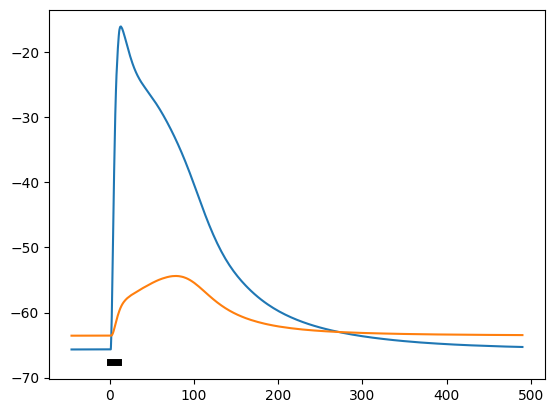

In [18]:
t = np.array(time)
v = np.array(volt)
s = np.array(soma_volt)
sel = (t > stim_start - 50)
plt.plot(t[sel] - stim_start, v[sel])
plt.plot(t[sel] - stim_start, s[sel])
plt.plot([stim_start - stim_start, stim_end - stim_start], [v[sel][0]-2, v[sel][0]-2], 'k', lw=5)